In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
def f(x):
    return 2**(np.cos(x**2))

def J(x,N):
    return np.stack([x**k for k in range(N+1)], axis=1)

def h(x_i, theta):
    y_hat = 0
    for i in range(len(theta)):
        y_hat += theta[i]*(x_i**i)
    return y_hat

def h_vec(x, theta):
    return [h(x_i, theta) for x_i in x]

def loss(y, y_hat):
    return (y - y_hat)**2

def cost(y, y_hat):
    m = len(y)
    return (1/m) * np.sum(loss(y,y_hat))

def grad(x,y,theta):
    m = len(y)
    y_hat = h_vec(x, theta)
    r = y - y_hat
    J_mat = J(x, len(theta)-1)
    return (-2/m) * J_mat.T @ r

def wolfe_conditions(x, y, theta, p, alpha_init, c1=1e-4, c2=0.9):
    alpha = alpha_init
    phi_0 = cost(y, h_vec(x, theta))
    grad_0 = grad(x, y, theta)
    phi_alpha = cost(y, h_vec(x, theta + alpha * p))
    while phi_alpha > phi_0 + c1 * alpha * grad_0.T @ p:
        alpha *= 0.5
        phi_alpha = cost(y, h_vec(x, theta + alpha * p))
    grad_alpha = grad(x, y, theta + alpha * p)
    while grad_alpha.T @ p < c2 * grad_0.T @ p:
        alpha *= 1.1
        phi_alpha = cost(y, h_vec(x, theta + alpha * p))
        grad_alpha = grad(x, y, theta + alpha * p)
    return alpha


In [3]:
def gauss_newton(X:np.array, 
                 y:np.array, 
                 theta_0:np.array,
                 N:int, 
                 alpha:float = 1e-3,
                 max_iter:int = 1000, 
                 tol:float = 1e-5):
    x = X.copy()
    theta = theta_0.copy()
    alpha_k = alpha
    cost_history = []

    for i in range(max_iter):
        # Compute cost
        y_hat = h_vec(x, theta)
        cost_history.append(cost(y, y_hat))
        # Verify stop criteria
        grad_k = grad(x, y, theta)
        if np.linalg.norm(grad_k) < tol:
            print(f"Convergió en la iteración {i}")
            break
        # Compute J_k and r_k
        J_k = J(x, N)
        h_k = h_vec(x, theta)
        r_k = h_k - y
        # Comppute A_k = J_{k}^{T}*J_k 
        A_k = J_k.T @ J_k
        # Compute b_k = -J_{k}^{T}*r_k
        b_k = -J_k.T @ r_k
        # Solve A_k*P_k = b_k
        P_k = np.linalg.solve(A_k, b_k)
        # Compute alpha_k (wolfe conditions)
        alpha_k = wolfe_conditions(x, y, theta, P_k, alpha_k)
        # theta = theta + alpha_k*P_k
        theta = theta + alpha_k*P_k
    return theta, cost_history


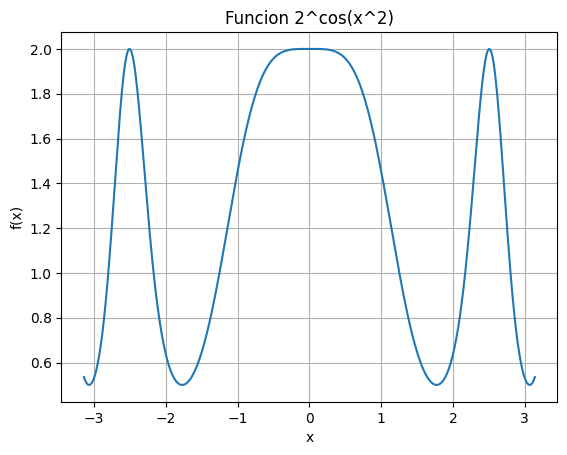

In [4]:
x = np.linspace(-np.pi, np.pi, 500)
y = f(x)

plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Funcion 2^cos(x^2)')
plt.grid()
plt.show()

In [5]:
N_tests = [2, 4, 8, 12, 16, 20]
costs = []
y_hats = []
x_norm = x / np.pi 
for N in N_tests:
    print(f"Optimizando con N={N}")
    theta0 = np.zeros(N+1)
    theta, cost_history = gauss_newton(x_norm, y, theta0, N, alpha=0.01)
    y_hat = h_vec(x_norm, theta)
    costs.append(cost_history)
    y_hats.append(y_hat)

Optimizando con N=2
Convergió en la iteración 109
Optimizando con N=4
Convergió en la iteración 109
Optimizando con N=8
Convergió en la iteración 110
Optimizando con N=12
Convergió en la iteración 110
Optimizando con N=16
Convergió en la iteración 110
Optimizando con N=20
Convergió en la iteración 110


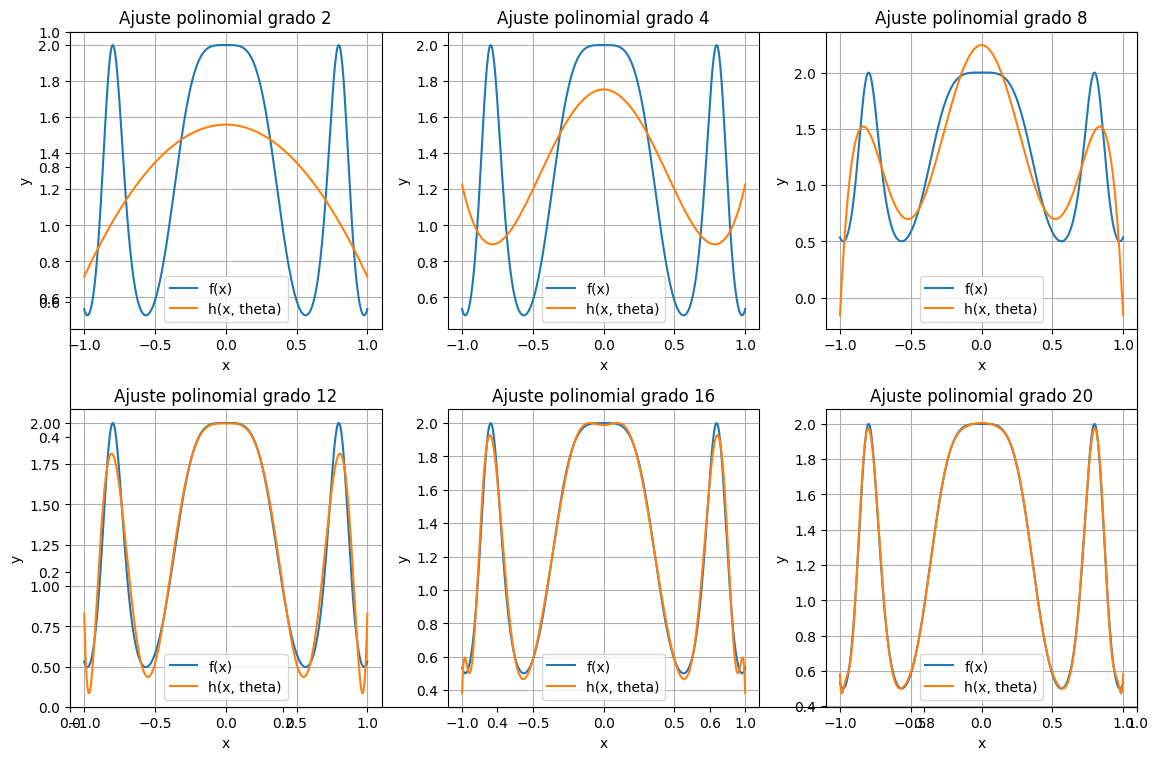

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
for i, N in enumerate(N_tests):
    ax = plt.subplot(2, 3, i+1)
    ax.plot(x_norm, y, label='f(x)')
    ax.plot(x_norm, y_hats[i], label='h(x, theta)')
    ax.set_title(f'Ajuste polinomial grado {N}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

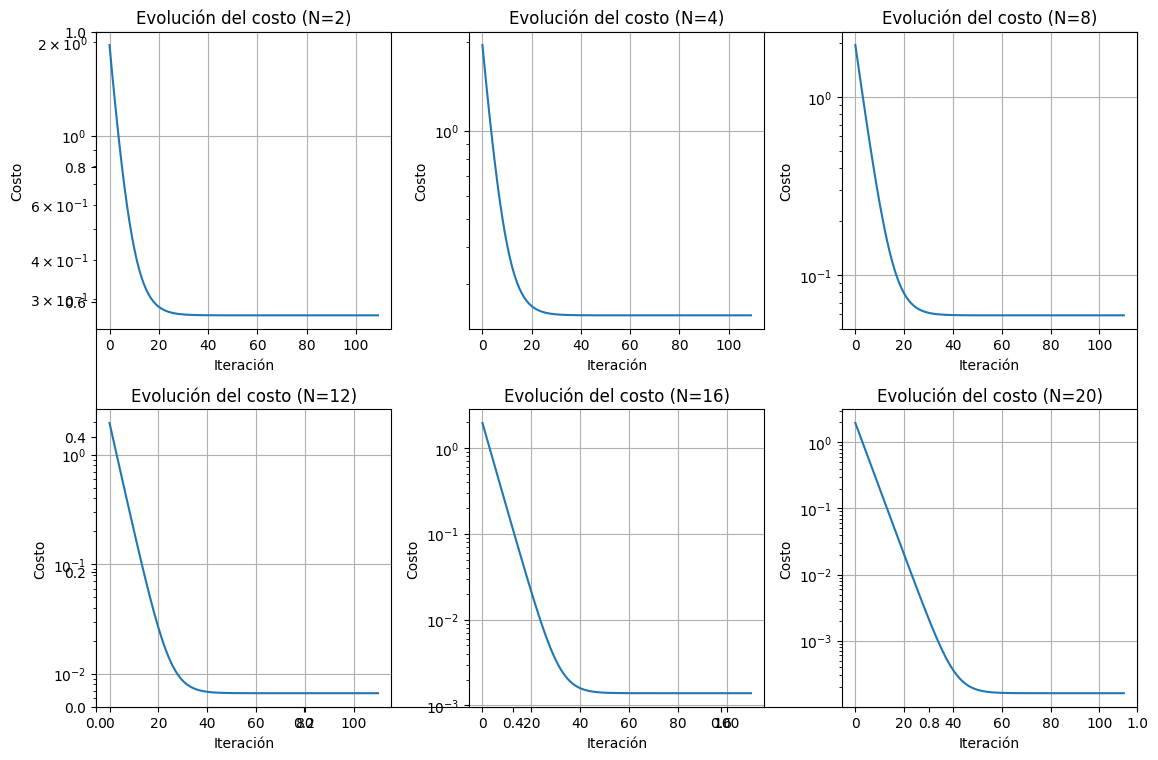

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
for i, N in enumerate(N_tests):
    ax = plt.subplot(2, 3, i+1)
    ax.plot(range(len(costs[i])), costs[i])
    ax.set_title(f'Evolución del costo (N={N})')
    ax.set_xlabel('Iteración')
    ax.set_ylabel('Costo')
    ax.set_yscale('log')
    ax.grid()
plt.tight_layout()
plt.show()